In [20]:
#Credit: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from sklearn.cross_validation import train_test_split
from collections import defaultdict
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text 
import re
import findspark
findspark.init()
import pyspark
from pyspark.sql import SQLContext


stopwords=text.ENGLISH_STOP_WORDS



In [2]:
# Read and store csv data in to Master index

bike_masterdf = pd.read_csv('./bike_details.csv')
print "Number of samples in the database:", bike_masterdf.shape[0]
bike_masterdf.head(2)

Number of samples in the database: 59619


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
0,0,50088,Schwinn Gateway,absent,Schwinn,Gateway,NaN,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-07-06 22:27:01,2015-11-03 05:36:54,https://bikeindex.org/bikes/50088,https://bikeindex.org/api/v1/bikes/50088,117,NaN,NaN,NaN,NaN,True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1436221621,1446529014,0
1,1,60140,2016 Specialized Diverge Elite DSW,WSBC601010269K,Specialized,Diverge Elite DSW,2016,NaN,NaN,False,False,NaN,1970-01-01 00:00:00,2015-10-08 19:18:50,2015-11-03 05:34:30,https://bikeindex.org/bikes/60140,https://bikeindex.org/api/v1/bikes/60140,307,NaN,NaN,52cm,NaN,True,NaN,Bike,False,NaN,NaN,NaN,aluminum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1444331930,1446528870,0


In [3]:
# Remove nulls in theft description - only stolen bikes have theft description -> store in filtered dataframe
num_stolen = len(bike_masterdf.stolen[bike_masterdf.stolen == True])
print "Number of bikes reported as stolen: ", num_stolen
print "Proportion of bikes reported as stolen:  %.2f" % (float(num_stolen)/float(bike_masterdf.shape[0]))
desc_mask = bike_masterdf.theft_description.isnull()
bike_subdf = bike_masterdf[~desc_mask]
print "Number of Stolen bikes with theft description:", bike_subdf.shape[0]

#bike_subdf.to_json('./stolen_bikes.json')
bike_subdf.head(2)

Number of bikes reported as stolen:  33182
Proportion of bikes reported as stolen:  0.56
Number of Stolen bikes with theft description: 29838


,Unnamed: 0,id,title,serial,manufacturer_name,frame_model,year,thumb,large_img,is_stock_img,stolen,stolen_location,date_stolen,registration_created_at,registration_updated_at,url,api_url,manufacturer_id,paint_description,name,frame_size,description,rear_tire_narrow,front_tire_narrow,type_of_cycle,test_bike,rear_wheel_size_iso_bsd,front_wheel_size_iso_bsd,handlebar_type_slug,frame_material_slug,front_gear_type_slug,rear_gear_type_slug,stolen_id,s_date_stolen,s_location,latitude,longitude,theft_description,locking_description,lock_defeat_description,police_report_number,police_report_department,s_rec_created_at,create_open311,sder_formatted_address,sder_street_number,sder_route,sder_postal_code,sder_neighborhood,sder_city,sder_county,sder_state,sder_country,date_stolen_epoch,registration_created_at_epoch,registration_updated_at_epoch,s_rec_created_at_epoch
3,3,11542,2013 Trek 4300,WTU124C5170G,Trek,4300,2013,NaN,NaN,False,True,"San Jose, CA, 95126",2013-06-10 06:00:00,2013-08-20 06:00:00,2015-11-03 05:11:14,https://bikeindex.org/bikes/11542,https://bikeindex.org/api/v1/bikes/11542,47,NaN,NaN,NaN,"Trek 4300, Mountain bicycle, disc brakes, blac...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,7889,1370844000,"San Jose, CA, 95126",37.329012,-121.916021,bike rack,NaN,NaN,T13006853,San Jose,2014-06-14 17:52:49,False,"1323 Martin Ave, San Jose, CA 95126, USA",1323,Martin Avenue,95126,Shasta-Hanchett Park,San Jose,Santa Clara County,California,United States,1370844000,1376978400,1446527474,1402768369
4,4,13359,2010 Schwinn Katana,absent,Schwinn,Katana,2010,https://files.bikeindex.org/uploads/Pu/4903/sm...,https://files.bikeindex.org/uploads/Pu/4903/la...,False,True,"Sandusky, OH, 44870",2010-07-10 06:00:00,2010-07-11 06:00:00,2015-11-03 05:17:53,https://bikeindex.org/bikes/13359,https://bikeindex.org/api/v1/bikes/13359,117,NaN,NaN,58cm,"The bike is a grey, blue, and black Schwinn Ka...",True,NaN,Bike,False,NaN,NaN,NaN,NaN,NaN,NaN,9705,1278741600,"Sandusky, OH, 44870",41.440356,-82.768114,car bike rack Reward: $75,NaN,NaN,2010004433,Sandusky,2014-06-14 18:17:08,False,"4614 Venice Heights Blvd, Sandusky, OH 44870, USA",4614,Venice Heights Boulevard,44870,NaN,Sandusky,Erie County,Ohio,United States,1278741600,1278828000,1446527873,1402769828


In [4]:
theft_desc_word_count = bike_subdf.theft_description.apply(lambda x: len(x.split()))
#theft_desc_word_count = np.array(theft_desc_list.apply(lambda x: len(x.split())))


Theft description with maximum word count: 558
Theft description with minimum word cunt:  0
Average word count of description: 10.21


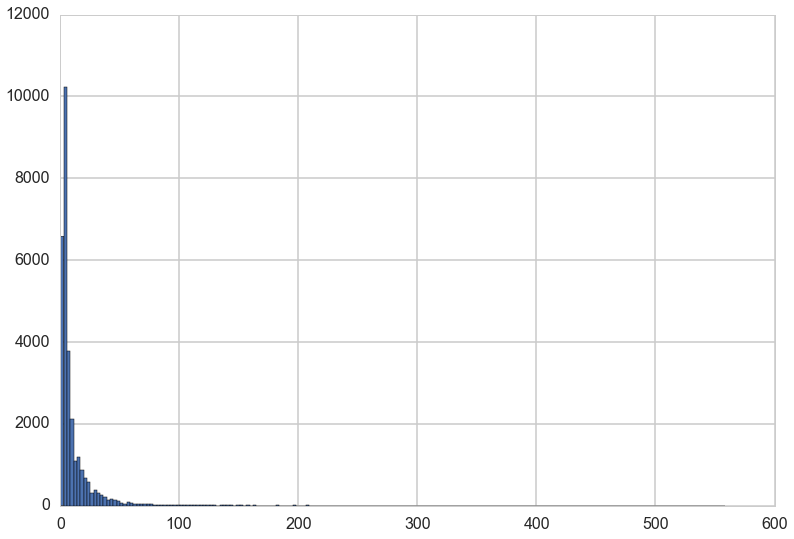

In [5]:
theft_desc_word_count.hist(bins=200)
print "Theft description with maximum word count:", max(theft_desc_word_count)
print "Theft description with minimum word cunt: ", min(theft_desc_word_count)
print "Average word count of description: %.2f" % np.mean(theft_desc_word_count)

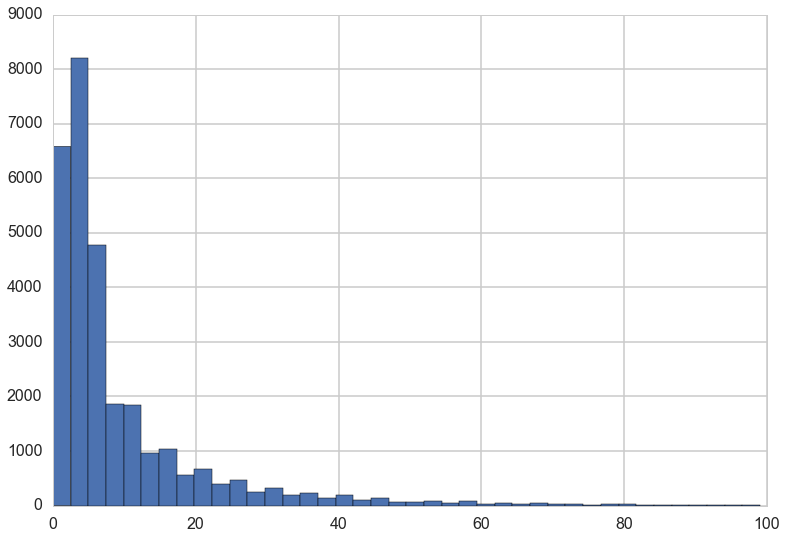

In [6]:
theft_desc_word_count_small = theft_desc_word_count[theft_desc_word_count < 100]
theft_desc_word_count_large = theft_desc_word_count[theft_desc_word_count > 100]
theft_desc_word_count_small.hist(bins=40)



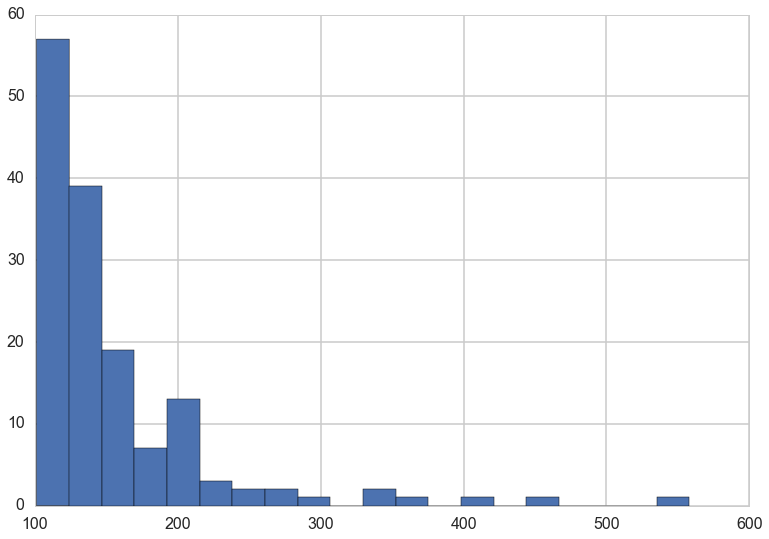

In [7]:
theft_desc_word_count_large.hist(bins=20)

In [8]:
#TEMP:
print (bike_subdf.theft_description[0:10])

3                                             bike rack
4                             car bike rack Reward: $75
5                      Backyard Reward: I have no money
6                              Open Garage Reward: $300
7     15\\" thick steel hand railing to which my bik...
8                              Powell Park Reward: $100
9                 PCC SE Campus at SE 82nd and Division
10                                         Reward: $150
11    A bike rack. Reward: A BIG HUG, MAYBE MONEY TO...
13                                                     
Name: theft_description, dtype: object


In [9]:
#Unnecessary i think when we are 'NOT' predicting anything
# Split data in to training + testing
itrain, itest = train_test_split(xrange(bike_subdf.shape[0]), train_size=0.7)
mask=np.ones(bike_subdf.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)



In [10]:
#Process each document (theft description belonging to each sample) by removing stop words, punctuations etc.
# Trail run on training data
#setting min_df =1
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X = vectorizer.fit_transform(bike_subdf.theft_description)    #************* May need to use mask for train/test 
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.iteritems())
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [11]:
corpus_gensim.sparse.shape

(12172, 29838)

In [12]:
# 1st model using LDA  to understand semantics of classifier
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=2, update_every=1, chunksize=100, passes=1)

In [13]:
print lda.print_topics()

[u'0.074*bike + 0.035*stolen + 0.033*locked + 0.021*lock + 0.015*apartment + 0.014*garage + 0.012*building + 0.012*cut + 0.010*inside + 0.010*left', u'0.203*reward + 0.059*rack + 0.056*100 + 0.044*bike + 0.040*50 + 0.035*garage + 0.029*00 + 0.022*200 + 0.020*home + 0.012*yes']


In [14]:
print "The above was a direct LDA run on the data related to theft description. We can see that there is a lot of garbage that needs to be filtered out of the descriptions to make topic selection better"

print "We can use Penn Treebank II tag set to parse the worse and filter words that do not apply to our topic selection.\
The basic exercise here is to identify specific details pertaining to where the bikes were stole from. Mostly these will be captured \
by the nouns. Let us start by only looking for nouns"


The above was a direct LDA run on the data related to theft description. We can see that there is a lot of garbage that needs to be filtered out of the descriptions to make topic selection better
We can use Penn Treebank II tag set to parse the worse and filter words that do not apply to our topic selection.The basic exercise here is to identify specific details pertaining to where the bikes were stole from. Mostly these will be captured by the nouns. Let us start by only looking for nouns


In [30]:
# Create function to parse incoming text, tokenize and check for  ******* Nouns and Proper Nouns
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")
regex3=re.compile(r"\\\\")
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')



def gather_nouns(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    thetext=re.sub(regex3, ' ', thetext)
    #thetext=re.sub(regex4, ' ', thetext)

    nouns=[]
    #descriptives=[]
    for sentence in parse(thetext, tokenize=True, lemmata=True).split():
        
        #nouns.append([])
        #descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
               # if token[1] in ['JJ', 'JJR', 'JJS']:
               #     if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
               #         continue
               #     descriptives[i].append(token[4])
                if token[1] in ['NN', 'NNS','NNP', 'NNPS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns.append(token[4])
    #out=zip(nouns, descriptives)
    #print nouns
    nouns2=[]
    #descriptives2=[]
    for n in nouns:
        if len(n)!=0: #and len(d)!=0:
            nouns2.append(n)
            #print len(n)
            #descriptives2.append(d)
    #print len(nouns) , nouns2
 
    return ' '.join(nouns2)
    

In [31]:

print gather_nouns("The bike was locked to a sign pole by the corner of the superstore. The lock was a combination lock and i had \
tied chained my helmet to the bike. The bike was of make 'GT' with shimano gears and had a custom seat")
parsed_nouns = bike_subdf.theft_description.apply(gather_nouns)

bike sign pole corner superstore lock combination lock helmet bike bike make gt shimano gear custom seat


In [32]:

#Tokenize each theft description to return a list of nouns, proper nouns etc for each sample (row)

vectorizer_nouns = CountVectorizer(min_df=1, stop_words='english')
X_nouns = vectorizer_nouns.fit_transform(parsed_nouns)    #************* May need to use mask for train/test 
id2words_nouns = dict((v, k) for k, v in vectorizer_nouns.vocabulary_.iteritems())
corpus_gensim_nouns = gensim.matutils.Sparse2Corpus(X_nouns, documents_columns=False)

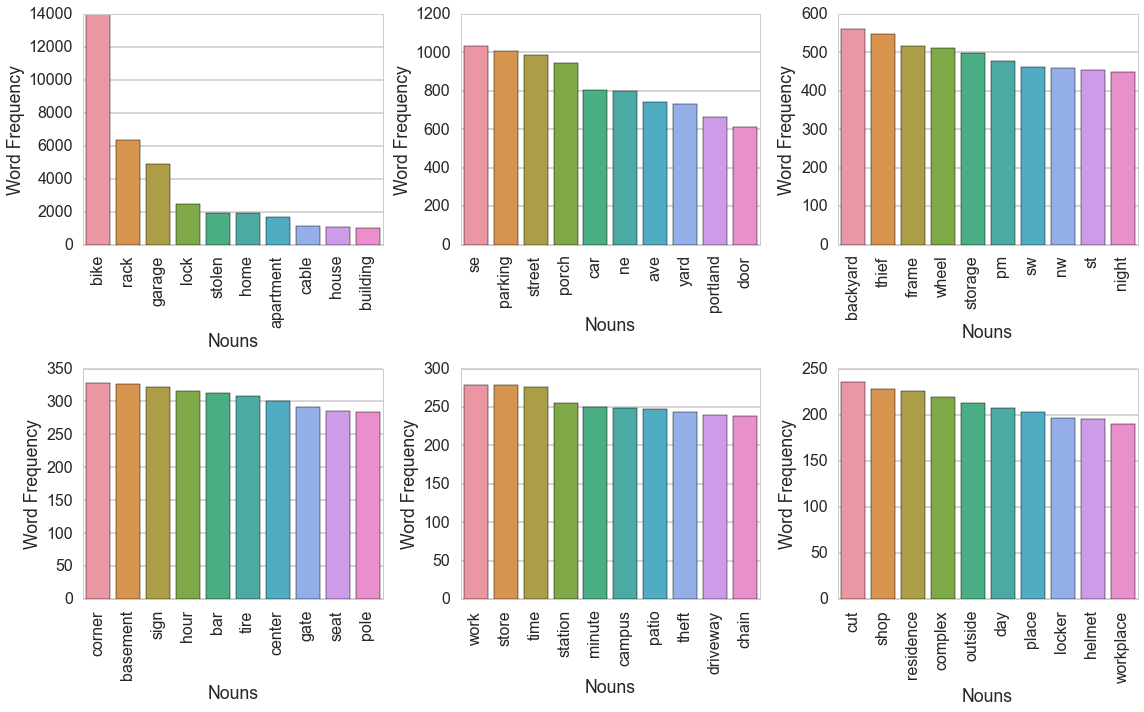

In [140]:
# From vectorizer, gather word-frequency data to look for highy frequency words
#Plot bar graph to understand 
#Credit: http://stackoverflow.com/questions/16078015/list-the-words-in-a-vocabulary-according-to-occurrence-in-a-text-corpus-scikit
Nouns = vectorizer_nouns.get_feature_names()
Noun_Counts = np.asarray(X_nouns.sum(axis=0)).ravel()
#word_freq_dict = {'Nouns': Nouns, 'Count':Noun_Counts}
#word_frequency = zip(vectorizer_nouns.get_feature_names(),np.asarray(X_nouns.sum(axis=0)).ravel())
word_frequency = pd.DataFrame({'Nouns': Nouns, 'Count':Noun_Counts})
sorted_w_freq_df = word_frequency.sort(columns='Count', ascending=False)

# Frequency of first 60 words 
#
nrows=2
ncols=3
plt_rows = np.arange(nrows)
plt_cols = np.arange(ncols)
f1, ax1 = plt.subplots(figsize=(16,10), nrows=nrows, ncols=ncols)
f1.set_tight_layout(True)
x = 0

for row in plt_rows:
    for col in plt_cols:
        a = sns.barplot(x='Nouns',y='Count',data= sorted_w_freq_df[x:x+10], ax=ax1[row][col])
        a.set_xticklabels(sorted_w_freq_df['Nouns'][x:x+10].tolist(), rotation='vertical')
        a.set_ylabel('Word Frequency')
        x+=10
    x+=10




#Write word(Noun)-frequency to CSV
word_frequency.to_json('./noun_frequency.json')

In [48]:
print corpus_gensim_nouns.sparse.shape
num_topics=range(2,11)
lda_models_dict={}

for eachtopic in num_topics:
    lda_nouns = gensim.models.ldamodel.LdaModel(corpus_gensim_nouns, id2word=id2words_nouns, num_topics=eachtopic, update_every=1, chunksize=100, passes=5)
    lda_models_dict[eachtopic]=lda_nouns.top_topics(corpus_gensim_nouns,num_words=15)


(7544, 29838)


In [86]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

for key in lda_models_dict.keys():    
    print "Number of topics: ", key
    pp.pprint (lda_models_dict[key])
    

Number of topics:  2
[   (   [   (0.20682033879356856, u'bike'),
            (0.10420388009013035, u'rack'),
            (0.033037319416122236, u'lock'),
            (0.019910211959868331, u'house'),
            (0.016165960018206315, u'car'),
            (0.01492746409621562, u'cable'),
            (0.010426552014271591, u'yard'),
            (0.0090428525061796907, u'backyard'),
            (0.0081681251131399818, u'frame'),
            (0.0076887491105789053, u'thief'),
            (0.0072532743853823706, u'wheel'),
            (0.0072203894249881478, u'storage'),
            (0.0064597669681848002, u'room'),
            (0.0056749300350533872, u'bicycle'),
            (0.0053341864176967829, u'work')],
        -659.068371030756),
    (   [   (0.10516497333559541, u'garage'),
            (0.041486587971745668, u'home'),
            (0.033671299841028367, u'stolen'),
            (0.032017828057108871, u'apartment'),
            (0.027059852042377718, u'parking'),
            (0.02243